In [28]:
import pandas as pd
import torch
import re
import nltk
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [29]:
# Ensure necessary NLTK resources are available
def download_nltk_resources():
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('vader_lexicon')

download_nltk_resources()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ronal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ronal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ronal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [30]:
# Load dataset
file_path = "Steam review data from previous study(in).csv"
df = pd.read_csv(file_path, encoding='utf-8')

if 'review' not in df.columns:
    raise ValueError("The dataset does not contain a 'review' column")

df = df[['recommendationid', 'review']].dropna().drop_duplicates()

In [31]:
# Define stopwords and negations
stop_words = set(stopwords.words('english'))
negations = {"not", "never", "none", "no", "don't", "haven't", "isn't"}
stop_words = stop_words - negations  # Keep negations

In [32]:
# Text preprocessing
def clean_text(text, remove_stopwords=True):
    text = re.sub(r"[^a-zA-Z0-9\s’']", "", text.lower().strip())
    words = word_tokenize(text)
    if remove_stopwords:
        words = [word for word in words if word not in stop_words or word in negations]
    return " ".join(words)

In [33]:
# Process reviews
def split_into_sentences(row):
    sentences = [s for s in sent_tokenize(str(row['review'])) if re.search(r"[a-zA-Z0-9]", s)]
    return [{"recommendationid": row["recommendationid"],
             "sentence_with_stopwords": clean_text(s, False),
             "sentence_without_stopwords": clean_text(s)} for s in sentences]

df_sentences = pd.DataFrame([entry for _, row in df.iterrows() for entry in split_into_sentences(row)]).drop_duplicates()


In [34]:
# Sentiment analysis setup
sia = SentimentIntensityAnalyzer()

In [35]:
# Load BERT model for sentiment analysis
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

In [36]:
def get_vader_sentiment(text):
    scores = sia.polarity_scores(text)
    return 1 if scores['compound'] >= 0 else 0

def get_bert_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model(**inputs)
    scores = outputs.logits.softmax(dim=1).cpu().detach().numpy()[0]
    return 1 if np.argmax(scores) > 2 else 0

df_sentences['vader_sentiment'] = df_sentences['sentence_with_stopwords'].apply(get_vader_sentiment)
df_sentences['bert_sentiment'] = df_sentences['sentence_with_stopwords'].apply(get_bert_sentiment)
df_sentences['combined_sentiment'] = (df_sentences['vader_sentiment'] + df_sentences['bert_sentiment']) / 2

def final_sentiment(value):
    return 1 if value > 0.5 else 0

df_sentences['final_sentiment'] = df_sentences['combined_sentiment'].apply(final_sentiment)

Model Accuracy: 0.7142857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57       601
           1       1.00      0.65      0.79      2612

    accuracy                           0.71      3213
   macro avg       0.70      0.82      0.68      3213
weighted avg       0.89      0.71      0.75      3213



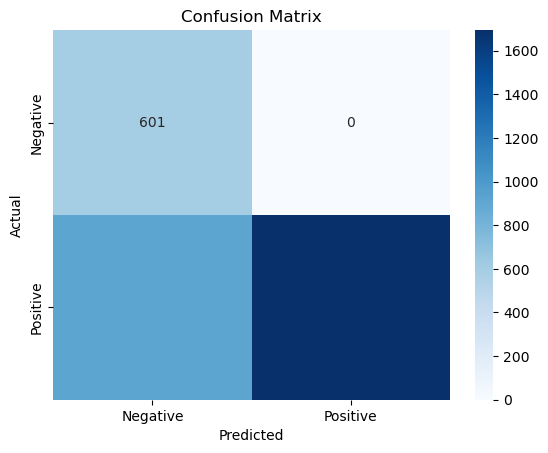

In [37]:
# Evaluation
true_labels = df_sentences['vader_sentiment'].tolist()
pred_labels = df_sentences['final_sentiment'].tolist()

print("Model Accuracy:", accuracy_score(true_labels, pred_labels))
print("Classification Report:\n", classification_report(true_labels, pred_labels))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()